In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import h5py
import copy
from VAE_convolution import VAE, generate_random_image, generate_random_one_hot,generate_random_seed

In [2]:
# Check CUDA is available
if torch.cuda.is_available():

    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
    print("Training devide:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training devide: NVIDIA GeForce GTX 1050 Ti


In [3]:
data = []
data_test = []

M_raw = []
M_raw_test = []
#load monte carlo simulation generated raw data
with h5py.File('MC_2layers_MT.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']
        #train data
        data.append(dataset[:][:400])
        #test data
        data_test.append(dataset[:][400:500])

        M_raw.append(dataset[:].mean(axis=0).sum()/100)
        M_raw_test.append(dataset[:][400:500].mean(axis=0).sum()/100)


M_raw=np.array(M_raw)
M_raw_test=np.array(M_raw_test)
data=np.array(data)
data_test=np.array(data_test)

data=data.reshape(-1,2,10,10)
data_test=data_test.reshape(-1,2,10,10)

print('Train data shape {}'.format(data.shape))
print('Test data shape {}'.format(data_test.shape))

Train data shape (20000, 2, 10, 10)
Test data shape (5000, 2, 10, 10)


Temperature: 22 K
The two layers magnetization are [-0.17604903  0.34460426] respectively


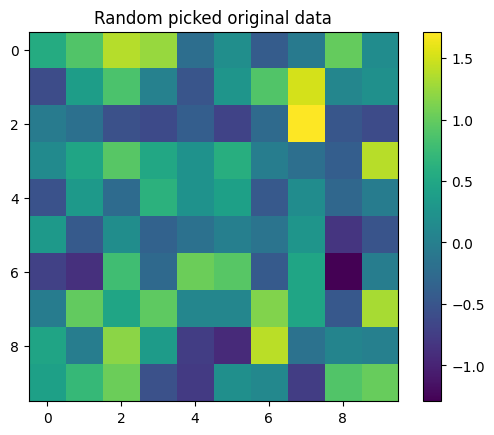

In [4]:
ii=np.random.randint(0,len(data))
print('Temperature: {} K'.format(int(ii/400)+1))
#original data plotting
plt.imshow(data[ii].sum(axis=0))#.cpu().detach().numpy()
plt.title('Random picked original data')
plt.colorbar()
print('The two layers magnetization are {} respectively'.format(data[ii].reshape(2,-1).sum(axis=1)/100))

In [5]:
#Temperature 1-50K
data_num = 50
T = np.linspace(1,50,data_num)

#One hot coding
One_hot_code=[]
for i in range(len(T)):
    for j in range(400):
        code=np.zeros(len(T))
        code[i]=1
        One_hot_code.append(code)
One_hot_code=np.array(One_hot_code)

#Transform the train data into [0,1],turn into tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)

One_hot_code=torch.tensor(One_hot_code).to(torch.float32)

print(data_set.detach().shape)
print(One_hot_code.detach().shape)

#Consolidate data and One hot coding
data_all=[]
for i in range(len(data)):
    data_all.append([data_set[i], One_hot_code[i]])

torch.Size([20000, 2, 10, 10])
torch.Size([20000, 50])


In [10]:
batch_size=200

data_loader = torch.utils.data.DataLoader(dataset=data_all,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          generator=torch.Generator(device = 'cuda'))

In [11]:
image_size = 2*10*10
h_dim = 500
z_dim = 50
num_epochs = 500
# batch_size = 128
learning_rate = 2e-4
class_num = 50

model = VAE(h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate,class_num=class_num).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
kl_losses=[]
reconstruction_losses=[]

for epoch in range(num_epochs) : # 开始训练
    train_loss = 0
    kl_loss=0
    reconstruction_loss=0
    
    # train_acc = 0
    # model.train()
    for imgs, labels in data_loader :
        imgs = imgs.to(device)
        labels = labels.to(device)
        # labels = labels.to(device)
        # real_imgs = torch.flatten(imgs)#, start_dim=1
        # real_imgs = imgs.view(-1,image_size)
        # Forward propagation
        gen_imgs, mu, log_var = model.forward(imgs, labels)

        
        # model.Train(gen_imgs, real_imgs, mu, log_var, batch_size)

        # Loss_F = nn.BCELoss(reduction='sum')#
        Loss_F = nn.MSELoss(reduction='sum')#

        rec_loss = Loss_F(gen_imgs, imgs)/batch_size

        KL_divergence = -0.5 * torch.sum(1 + log_var - torch.exp(log_var) - mu ** 2)/batch_size

        total_Loss = rec_loss+KL_divergence#record loss,kl+recons       

        # Back propagation
        optimizer.zero_grad()
        total_Loss.backward()
        optimizer.step()


        train_loss += total_Loss.detach().item()#.item()
        kl_loss += KL_divergence.detach().item()#.item()
        reconstruction_loss += rec_loss.detach().item()#.item()



    train_losses.append(train_loss / len(data_loader))
    kl_losses.append(kl_loss / len(data_loader))
    reconstruction_losses.append(reconstruction_loss / len(data_loader))


    if (epoch+1)%50==0:
        print('Epoch: {}, train_loss: {}, kl_loss:{}, reconstruction_loss: {}.'.format(epoch+1, train_loss / len(data_loader), kl_loss / len(data_loader), reconstruction_loss / len(data_loader)))

Epoch: 50, train_loss: 11.918753814697265, kl_loss:0.0790620006248355, reconstruction_loss: 11.839691791534424.
Epoch: 100, train_loss: 11.885170936584473, kl_loss:0.07932509146630765, reconstruction_loss: 11.805845880508423.
Epoch: 150, train_loss: 11.867292165756226, kl_loss:0.08065274100750684, reconstruction_loss: 11.78663945198059.
Epoch: 200, train_loss: 11.85743269920349, kl_loss:0.08378533884882927, reconstruction_loss: 11.773647336959838.
Epoch: 250, train_loss: 11.849284973144531, kl_loss:0.08360477730631828, reconstruction_loss: 11.765680198669434.
Epoch: 300, train_loss: 11.84524676322937, kl_loss:0.08590961392968893, reconstruction_loss: 11.759337148666383.
Epoch: 350, train_loss: 11.842294120788575, kl_loss:0.08619810272008181, reconstruction_loss: 11.756096048355102.
Epoch: 400, train_loss: 11.837901849746704, kl_loss:0.08979587391018867, reconstruction_loss: 11.748106002807617.
Epoch: 450, train_loss: 11.835086402893067, kl_loss:0.0900440875813365, reconstruction_loss: 

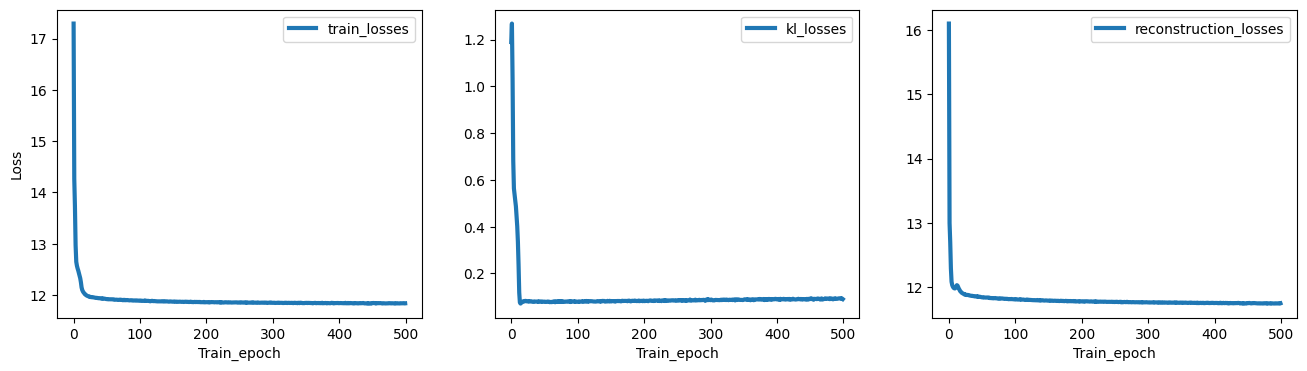

In [12]:
fig = plt.figure(figsize=(16,4)) 

ax1=plt.subplot(131)
ax1.plot(np.arange(len(train_losses)), train_losses, linewidth=3, linestyle='-', label='train_losses')
# ax1.set_title('Total_loss')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(len(kl_losses)), kl_losses, linewidth=3, linestyle='-', label='kl_losses')
# ax2.set_title('KL_loss')
ax2.set_xlabel('Train_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(len(reconstruction_losses)), reconstruction_losses, linewidth=3, linestyle='-', label='reconstruction_losses')
# ax3.set_title('reconstruction_losses')
ax3.set_xlabel('Train_epoch')
ax3.legend()

Temperature: 36 K
[0.05464645 0.04371426] [0.11118252 0.0636208 ]


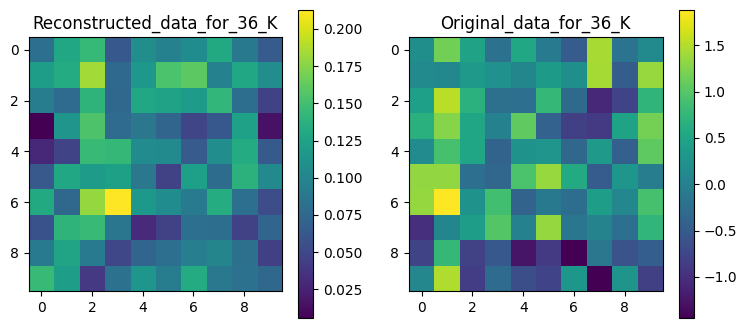

In [27]:
#reconstruction
ii=np.random.randint(0,len(data))
print('Temperature: {} K'.format(int(ii/400)+1))
img = data_set[ii].to(device)#.reshape(-1,2*10*10)
label_tensor = data_all[ii][1].reshape(-1,50)

# img = (img+1)/2
# labels = labels.to(device)
# real_img = torch.flatten(img)#, start_dim=1

reconstruct_img, _, _ = model(img,label_tensor)

reconstruct_img=reconstruct_img.view(2,10,10)
reconstruct_img_1=reconstruct_img*2-1

fig = plt.figure(figsize=(9,4)) 
ax1=plt.subplot(121)
a1=ax1.imshow(reconstruct_img_1.cpu().detach().numpy().sum(axis=0))#
ax1.set_title('Reconstructed_data_for_{}_K'.format(int(ii/400)+1))
plt.colorbar(a1,ax=ax1)

ax2=plt.subplot(122)
a2=ax2.imshow(data[ii].reshape(2,10,10).sum(axis=0))#
ax2.set_title('Original_data_for_{}_K'.format(int(ii/400)+1))
plt.colorbar(a2,ax=ax2)

print((reconstruct_img_1.reshape(2,-1).sum(axis=1)/100).detach().cpu().numpy(), data[ii].reshape(2,-1).sum(axis=1)/100)

7


tensor([-0.8464,  0.8704], grad_fn=<DivBackward0>)

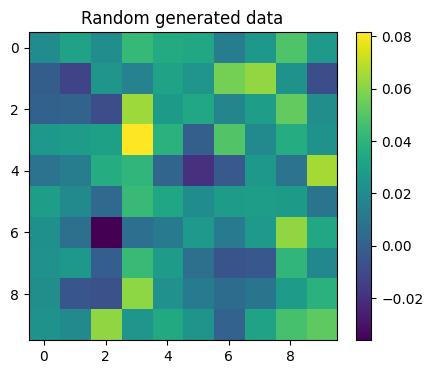

In [16]:
#Random generation
Code=torch.zeros(50)
Temperature=np.random.randint(1,50)
print(Temperature)
Code[Temperature-1]=1.0
z = torch.randn(z_dim).reshape(-1,z_dim).to(device)
out = model.decode(z, Code.reshape(-1,50)).view(2,10,10)*2-1

fig = plt.figure(figsize=(5,4)) 
plt.imshow(out.sum(axis=0).cpu().detach().numpy())
plt.title('Random generated data')
plt.colorbar()
out.reshape(2,-1).sum(axis=1)/100

In [17]:
M_T=[]
Susceptibility = []
sample_num=300
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    
    cal_M = 0
    cal_M_2=0
    for jj in range(sample_num):
        output=model.decode(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1
        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2
    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num


    M_T.append(copy.deepcopy(cal_M))
    Susceptibility.append(copy.deepcopy((1/(ii+1))*(cal_M_2-cal_M**2)))

M_T=np.array(M_T)
Susceptibility=np.array(Susceptibility)

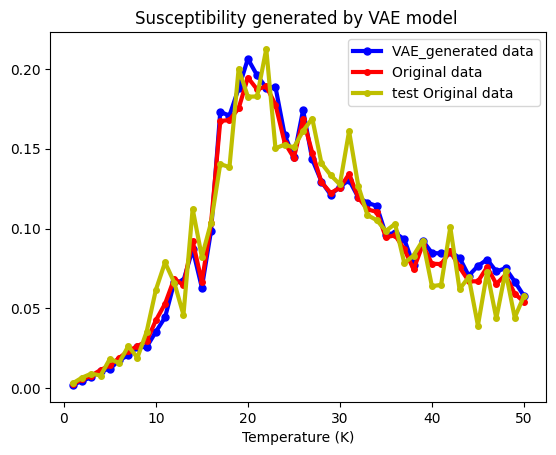

In [22]:
plt.plot(T, M_T,'bo-',markersize=5,lw=3, label='VAE_generated data')
plt.plot(T, M_raw,'ro-',markersize=4,lw=3, label='Original data')
plt.plot(T, M_raw_test,'yo-',markersize=4,lw=3, label='test Original data')


plt.title('Susceptibility generated by VAE model ')
plt.xlabel('Temperature (K)')
# plt.ylabel('M')
plt.legend()

Text(0, 0.5, 'Susceptibility')

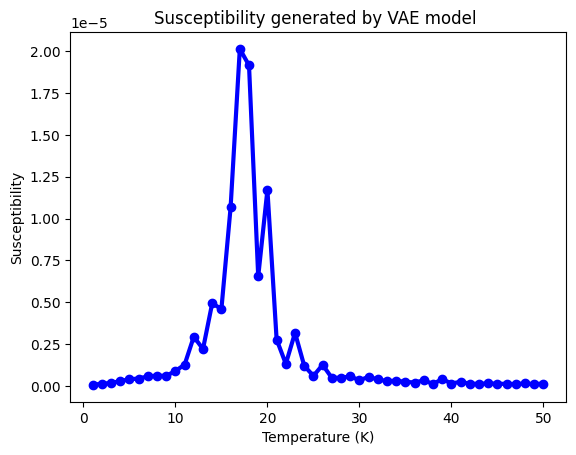

In [20]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.title('Susceptibility generated by VAE model ')
plt.xlabel('Temperature (K)')
plt.ylabel(r'Susceptibility')